In [ ]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [ ]:
!pip install keras_cv -q

In [ ]:
!pip install --upgrade keras

In [ ]:
!pip install segmentation_models

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import keras
from tensorflow.keras import ops
import keras_cv
import numpy as np
import segmentation_models as sm
from keras_cv.datasets.pascal_voc.segmentation import load as load_voc
from tensorflow.keras import backend as K

Segmentation Models: using `tf.keras` framework.


In [ ]:
!mkdir -p ~/.keras/datasets
!wget -qO- https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/semantic_contours/benchmark.tgz \
  | tar -xz -C ~/.keras/datasets


from keras_cv.datasets import pascal_voc
import os

BASE_DIR = f"{os.path.expanduser('~')}/.keras/datasets"
train_ds = pascal_voc.segmentation.load(split="sbd_train", data_dir=BASE_DIR)
eval_ds  = pascal_voc.segmentation.load(split="sbd_eval",  data_dir=BASE_DIR)

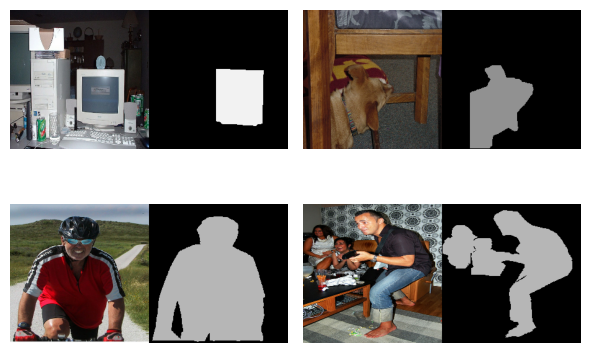

In [ ]:
def preprocess_tfds_inputs(inputs):
    def unpackage_tfds_inputs(tfds_inputs):
        return {
            "images": tfds_inputs["image"],
            "segmentation_masks": tfds_inputs["class_segmentation"],
        }

    outputs = inputs.map(unpackage_tfds_inputs)
    outputs = outputs.map(keras_cv.layers.Resizing(height=224, width=224))
    outputs = outputs.batch(32, drop_remainder=True)
    return outputs


train_ds = preprocess_tfds_inputs(train_ds)
batch = train_ds.take(1).get_single_element()
keras_cv.visualization.plot_segmentation_mask_gallery(
    batch["images"],
    value_range=(0, 255),
    num_classes=21,
    y_true=batch["segmentation_masks"],
    scale=3,
    rows=2,
    cols=2,
)

In [ ]:
eval_ds = preprocess_tfds_inputs(eval_ds)

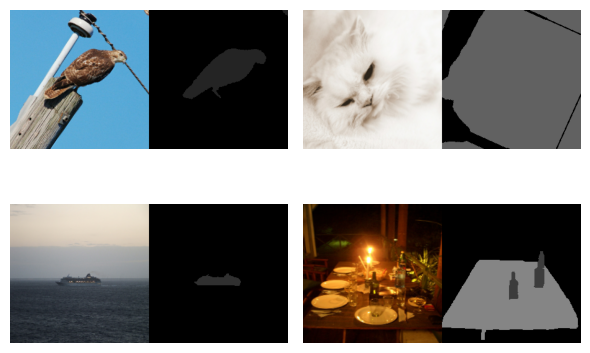

In [ ]:
train_ds = train_ds.map(keras_cv.layers.RandomFlip())
train_ds = train_ds.map(keras_cv.layers.RandomRotation(factor=.1,segmentation_classes=21))

batch = train_ds.take(1).get_single_element()

keras_cv.visualization.plot_segmentation_mask_gallery(
    batch["images"],
    value_range=(0, 255),
    num_classes=21,
    y_true=batch["segmentation_masks"],
    scale=3,
    rows=2,
    cols=2,
)

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate, Resizing
from tensorflow.keras.models import Model

def encoder_block(inputs, num_filters):
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    p = MaxPooling2D(pool_size=(2, 2), strides=2)(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    x = concatenate([x, skip_features])
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    return x



def unet_model(input_size=(224,224, 3)):
    inputs = Input(shape= input_size)
    #build the model
    # Encoder Phase
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # BottleNeck
    b1 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    b1 = Conv2D(1024, (3, 3), activation='relu', padding='same')(b1)

    # Decoder Phase
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(21, (1, 1), padding = 'valid', activation = 'softmax')(d4)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model


model = unet_model()


In [ ]:
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [ ]:
def jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [ ]:
metrics=['accuracy', jaccard_coef]
#compile the model
model.compile(optimizer='adam',
              loss=total_loss,
              metrics=['accuracy', jaccard_coef])

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 14, 14,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 14, 14,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 14, 14,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 28, 28,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 28, 28,    │          0 │ conv2d_transpose

 Total params: 31,033,045 (118.38 MB)

 Trainable params: 31,033,045 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def dict_to_tuple(x):


    return x["images"], tf.one_hot(
        tf.cast(tf.squeeze(x["segmentation_masks"], axis=-1), "int32"), 21
    )


train_ds = train_ds.map(dict_to_tuple)

eval_ds = eval_ds.map(dict_to_tuple)



In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath = "best_custom.weights.h5", monitor="val_loss", mode = "min", save_best_only = True, save_weights_only = True, verbose =1)
model.fit(train_ds, validation_data=eval_ds, epochs=10, callbacks=[checkpoint])

Epoch 1/10
    265/Unknown 775s 3s/step - accuracy: 0.6195 - jaccard_coef: 0.3237 - loss: 0.9784

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 0.94700, saving model to best_custom.weights.h5
265/265 ━━━━━━━━━━━━━━━━━━━━ 858s 3s/step - accuracy: 0.6196 - jaccard_coef: 0.3237 - loss: 0.9783 - val_accuracy: 0.6387 - val_jaccard_coef: 0.3626 - val_loss: 0.9470
Epoch 2/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6211 - jaccard_coef: 0.3615 - loss: 0.9450
Epoch 2: val_loss improved from 0.94700 to 0.94568, saving model to best_custom.weights.h5
265/265 ━━━━━━━━━━━━━━━━━━━━ 719s 3s/step - accuracy: 0.6211 - jaccard_coef: 0.3615 - loss: 0.9450 - val_accuracy: 0.5923 - val_jaccard_coef: 0.3910 - val_loss: 0.9457
Epoch 3/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6054 - jaccard_coef: 0.3784 - loss: 0.9367
Epoch 3: val_loss improved from 0.94568 to 0.92684, saving model to best_custom.weights.h5
265/265 ━━━━━━━━━━━━━━━━━━━━ 753s 3s/step - accuracy: 0.6054 - jaccard_coef: 0.3784 - loss: 0.9367 - val_accuracy: 0.5913 - val_jaccard_coef: 0.3693 - val_loss: 0.9268
Epoch 4/10

In [22]:
loss, accuracy, jaccard_coeff = model.evaluate(eval_ds)
print(f"Model loss: {loss:.4f}")
print(f"Model accuracy: {accuracy:.3f}")
print(f"Model Jaccard Coeffisiency: {jaccard_coeff:.3f}")

89/89 ━━━━━━━━━━━━━━━━━━━━ 48s 534ms/step - accuracy: 0.6210 - jaccard_coef: 0.4280 - loss: 0.8768
Model loss: 0.8764
Model accuracy: 0.624
Model Jaccard Coeffisiency: 0.431


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [23]:
activation='softmax'

LR = 0.001
optim = keras.optimizers.Adam(LR)


dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)


In [24]:
BACKBONE1 = 'mobilenetv2'

n_classes=21
# define model
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)
model1.compile(optim, total_loss, metrics=metrics)
print(model1.summary())

/usr/local/lib/python3.11/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_pad           │ (None, None,      │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, None,      │        864 │ Conv1_pad[0][0]   │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, None,      │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, None,      │          0 │ bn_Conv1[0][0]    │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │          0 │ expanded_conv_de… │
│ (ReLU)              │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, None,      │        512 │ expanded_conv_de… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, None,      │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, None,      │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, None,      │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, None,      │          0 │ block_1_expand_B… │
│ (ReLU)              │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, None,      │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, None,      │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, None,      │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, None,      │          0 │ block_1_depthwis

 Total params: 8,050,341 (30.71 MB)

 Trainable params: 8,014,245 (30.57 MB)

 Non-trainable params: 36,096 (141.00 KB)

None


In [25]:
flag = True
for l in model1.layers:
  if  l.name=='decoder_stage0_upsampling':
    flag = False
  if flag:
    l.trainable = False
  else:
    True

In [26]:
model1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_pad           │ (None, None,      │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, None,      │        864 │ Conv1_pad[0][0]   │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, None,      │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, None,      │          0 │ bn_Conv1[0][0]    │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │          0 │ expanded_conv_de… │
│ (ReLU)              │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, None,      │        512 │ expanded_conv_de… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, None,      │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, None,      │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, None,      │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, None,      │          0 │ block_1_expand_B… │
│ (ReLU)              │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, None,      │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, None,      │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, None,      │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, None,      │          0 │ block_1_depthwis

 Total params: 8,050,341 (30.71 MB)

 Trainable params: 5,790,373 (22.09 MB)

 Non-trainable params: 2,259,968 (8.62 MB)

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath = "freezed.weights.h5", monitor="val_loss", mode = "min", save_best_only = True, save_weights_only = True, verbose =1)

model1.fit(train_ds, validation_data=eval_ds, epochs=10, batch_size=32, callbacks=[checkpoint] )

Epoch 1/10
    265/Unknown 488s 2s/step - accuracy: 0.5242 - jaccard_coef: 0.2944 - loss: 0.9470
Epoch 1: val_loss improved from inf to 0.97499, saving model to freezed.weights.h5
265/265 ━━━━━━━━━━━━━━━━━━━━ 519s 2s/step - accuracy: 0.5245 - jaccard_coef: 0.2947 - loss: 0.9469 - val_accuracy: 0.4287 - val_jaccard_coef: 0.2141 - val_loss: 0.9750
Epoch 2/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6602 - jaccard_coef: 0.4290 - loss: 0.8899
Epoch 2: val_loss improved from 0.97499 to 0.91887, saving model to freezed.weights.h5
265/265 ━━━━━━━━━━━━━━━━━━━━ 439s 2s/step - accuracy: 0.6602 - jaccard_coef: 0.4290 - loss: 0.8899 - val_accuracy: 0.5166 - val_jaccard_coef: 0.3147 - val_loss: 0.9189
Epoch 3/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6501 - jaccard_coef: 0.4310 - loss: 0.8665
Epoch 3: val_loss improved from 0.91887 to 0.86799, saving model to freezed.weights.h5
265/265 ━━━━━━━━━━━━━━━━━━━━ 433s 2s/step - accuracy: 0.6500 - jaccard_coef: 0.4310 - loss: 0.

In [28]:
loss, accuracy, jaccard_coeff = model1.evaluate(eval_ds)
print(f"Model loss: {loss:.4f}")
print(f"Model accuracy: {accuracy:.3f}")
print(f"Model Jaccard Coeffisiency: {jaccard_coeff:.3f}")

89/89 ━━━━━━━━━━━━━━━━━━━━ 25s 279ms/step - accuracy: 0.7108 - jaccard_coef: 0.5443 - loss: 0.8187
Model loss: 0.8267
Model accuracy: 0.701
Model Jaccard Coeffisiency: 0.532


In [29]:
#let all the layers be trained
for l in model1.layers:
    l.trainable = True

In [30]:
LR = 0.000005
optim = keras.optimizers.Adam(LR)

In [31]:
model1.compile(optim, total_loss, metrics=metrics)

In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath = "full.weights.h5", monitor="val_loss", mode = "min", save_best_only = True, save_weights_only = True, verbose =1)

In [33]:
model1.fit(train_ds, validation_data=eval_ds, epochs=5, batch_size=32, callbacks=[checkpoint] )

Epoch 1/5
    265/Unknown 483s 2s/step - accuracy: 0.6487 - jaccard_coef: 0.4676 - loss: 0.8466
Epoch 1: val_loss improved from inf to 0.80820, saving model to full.weights.h5
265/265 ━━━━━━━━━━━━━━━━━━━━ 514s 2s/step - accuracy: 0.6488 - jaccard_coef: 0.4677 - loss: 0.8466 - val_accuracy: 0.6507 - val_jaccard_coef: 0.4688 - val_loss: 0.8082
Epoch 2/5
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6990 - jaccard_coef: 0.5220 - loss: 0.7726
Epoch 2: val_loss improved from 0.80820 to 0.74640, saving model to full.weights.h5
265/265 ━━━━━━━━━━━━━━━━━━━━ 466s 2s/step - accuracy: 0.6991 - jaccard_coef: 0.5221 - loss: 0.7726 - val_accuracy: 0.7089 - val_jaccard_coef: 0.5331 - val_loss: 0.7464
Epoch 3/5
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7248 - jaccard_coef: 0.5519 - loss: 0.7347
Epoch 3: val_loss improved from 0.74640 to 0.69667, saving model to full.weights.h5
265/265 ━━━━━━━━━━━━━━━━━━━━ 443s 2s/step - accuracy: 0.7248 - jaccard_coef: 0.5519 - loss: 0.7347 - val_a

In [34]:
loss, accuracy, jaccard_coeff = model1.evaluate(eval_ds)
print(f"Model loss: {loss:.4f}")
print(f"Model accuracy: {accuracy:.3f}")
print(f"Model Jaccard Coeffisiency: {jaccard_coeff:.3f}")

89/89 ━━━━━━━━━━━━━━━━━━━━ 25s 281ms/step - accuracy: 0.7750 - jaccard_coef: 0.6151 - loss: 0.6574
Model loss: 0.6551
Model accuracy: 0.774
Model Jaccard Coeffisiency: 0.614
